In [1]:
import time

from osm_runner import Runner  # pip install osm-runner
import pandas as pd

from arcgis.features import FeatureLayer, GeoAccessor, GeoSeriesAccessor
from arcgis.geoenrichment import enrich
from arcgis import dissolve_boundaries
from arcgis.geometry import project
from arcgis.gis import GIS
from arcgis.features import FeatureLayer, GeoAccessor, GeoSeriesAccessor
from arcgis.geoenrichment import enrich
from arcgis import dissolve_boundaries
from arcgis.geometry import project
from arcgis.gis import GIS

In [2]:
def str_to_cord(x):
    lat,long = float(x.split(",")[0]),float(x.split(",")[1])
    return lat,long

# Bahnhof

In [3]:
import requests
import json
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-1"="DE"][admin_level=2];
(node["name"="Bahnhof"](area);
 way["name"="Bahnhof"](area);
 rel["name"="Bahnhof"](area);
);
out center;
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data_Bahnhof = response.json()

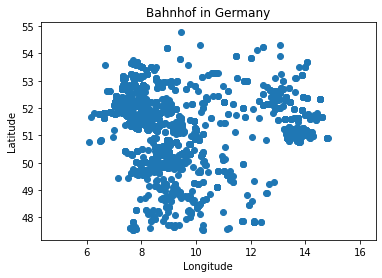

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# Collect coords into list
coords = []
for element in data_Bahnhof['elements']:
    if element['type'] == 'node':
        lon = element['lon']
        lat = element['lat']
        coords.append((lon, lat))
    elif 'center' in element:
        lon = element['center']['lon']
        lat = element['center']['lat']
        coords.append((lon, lat))
# Convert coordinates into numpy array
X = np.array(coords)
plt.plot(X[:, 0], X[:, 1], 'o')
plt.title('Bahnhof in Germany')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

In [5]:
import pandas as pd
df = pd.DataFrame()

In [6]:
df["lat"] = X[:, 1]
df["long"] =X[:, 0]
df["dummy"] = df.lat.apply(lambda x: str(round(x,5)))
df["dummy1"] = df.long.apply(lambda x: "," +str(round(x,5)))
df["dummy2"] = df.dummy+df.dummy1
df["cord"] = df.dummy2.apply(lambda x: str_to_cord(x))
df.drop(["dummy","dummy1","dummy2"],axis =1,inplace=True)

In [7]:
df.head()

,lat,long,cord
0,52.484531,8.011190,"(52.48453, 8.01119)"
1,52.484674,8.011273,"(52.48467, 8.01127)"
2,49.697984,10.805289,"(49.69798, 10.80529)"
3,53.769484,7.689019,"(53.76948, 7.68902)"
4,50.036696,8.605767,"(50.0367, 8.60577)"


In [8]:
dn =pd.read_pickle("stats.pickle")
#dn= dn[["city","latitude","longitude","park_id","postal_code"]]
dn["dummy"] = dn.latitude.apply(lambda x: str(round(x,5)))
dn["dummy1"] = dn.longitude.apply(lambda x: "," +str(round(x,5)))
dn["dummy2"] = dn.dummy+dn.dummy1
dn["cord"] = dn.dummy2.apply(lambda x: str_to_cord(x))
dn.drop(["dummy","dummy1","dummy2"],axis =1,inplace=True)

In [9]:
dn.head()

,evse_id,datetime_start,datetime_stop,city,park_id,latitude,longitude,postal_code,year,month,...,day_of_week_name_Start,Temperature,Precipitation,clc_code,area_code,Population_Density,Count_Charging,Charging_time_in_hours_log,Charging_time_in_min_log,cord
0,hj_AT*HTB*E100011,2019-02-10 10:28:53.836,2019-02-10 12:54:11.750,Rimsting,hj_AT*HTB*E10001,47.8772,12.3372,83253,2019,February,...,Sunday,5.133333,0.0,Industrial,057740032032,844.328749,159,0.884341,4.978686,"(47.8772, 12.3372)"
1,hj_AT*HTB*E100011,2019-02-15 08:33:09.428,2019-02-15 12:37:18.549,Rimsting,hj_AT*HTB*E10001,47.8772,12.3372,83253,2019,February,...,Friday,-2.233333,0.0,Industrial,057740032032,844.328749,159,1.403438,5.497783,"(47.8772, 12.3372)"
2,hj_AT*HTB*E100011,2019-02-19 14:12:56.548,2019-02-19 18:55:34.738,Rimsting,hj_AT*HTB*E10001,47.8772,12.3372,83253,2019,February,...,Tuesday,12.133333,0.0,Industrial,057740032032,844.328749,159,1.549806,5.644150,"(47.8772, 12.3372)"
3,hj_AT*HTB*E100011,2019-02-23 09:05:08.119,2019-02-23 14:41:49.291,Rimsting,hj_AT*HTB*E10001,47.8772,12.3372,83253,2019,February,...,Saturday,-1.133333,0.0,Industrial,057740032032,844.328749,159,1.724798,5.819143,"(47.8772, 12.3372)"
4,hj_AT*HTB*E100011,2019-02-25 11:32:44.019,2019-02-25 12:27:19.368,Rimsting,hj_AT*HTB*E10001,47.8772,12.3372,83253,2019,February,...,Monday,7.666667,0.0,Industrial,057740032032,844.328749,159,-0.094616,3.999729,"(47.8772, 12.3372)"


In [10]:
def  filter_lat_long(cord,th=0.1):
    la1,ln1 = cord
    dk = df.copy()
    return(
    dk
        [dk["lat"]<=la1+th]
        [dk["lat"]>=la1-th]
        [dk["long"]<=ln1+th]
        [dk["long"]>=ln1-th])


In [14]:
# 0.1 latitude is 11 km square
filter_lat_long(dn.cord.iloc[0],th=0.1)

<ipython-input-10-18750887360f>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dk


,lat,long,cord
1303,47.816399,12.380543,"(47.8164, 12.38054)"
2166,47.816346,12.380499,"(47.81635, 12.3805)"


In [17]:
import geopy
from geopy import distance
coords_1 = (52.2296756, 21.0122287)
coords_2 = (52.406374, 16.9251681)

print(distance.distance(coords_1, coords_2).km )

279.35290160430094


In [15]:
def nearest(c,th=0.1):
    dk = filter_lat_long(cord = c,th=th)
    if(len(dk)>0):
        dk["distance"] = dk.cord.apply(lambda x: distance.distance(c,x))
        dk = dk.sort_values("distance",ascending = True)
        v  = dk.distance.iloc[0].km
    else:
        v = 1000
    return v

In [18]:
nearest(dn.cord.iloc[0],th=0.2)

<ipython-input-10-18750887360f>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dk


7.498171845549429

In [19]:
dn["Nearest_Bahnhof_km"] = dn.cord.apply(lambda x :nearest(x,th=0.2))

<ipython-input-10-18750887360f>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dk


In [21]:
dn.to_pickle("bahnhof_OSM.pickle")

In [22]:
dn.to_csv("bahnhof_OSM.csv")